<a href="https://colab.research.google.com/github/shama-llama/crop-mapping/blob/main/src/crop_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crop Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px

%matplotlib inline
sns.set(style='whitegrid', palette='muted')

## 2. Data Loading & Initial Inspection

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/projects/crop-mapping-with-deep-learning/crop-mapping/dataset/winnipeg_dataset.csv')

# Create feature groups
radar_features_05jul = [f'f{i}' for i in range(1,50)]
radar_features_14jul = [f'f{i}' for i in range(50,99)]
optical_features_05jul = [f'f{i}' for i in range(99,137)]
optical_features_14jul = [f'f{i}' for i in range(137,175)]

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (325834, 175)


,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,...,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,...,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,...,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,1,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,...,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,1,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,...,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000


## 3. Exploratory Data Analysis
### 3.1. Class Distribution Analysis

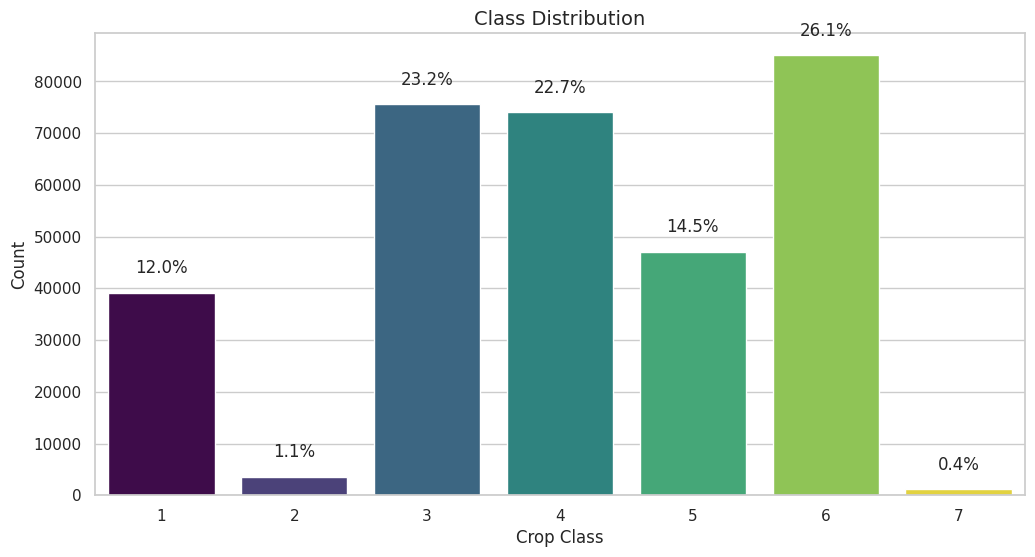

In [ ]:
# Class distribution
plt.figure(figsize=(12,6))
ax = sns.countplot(x='label', data=df, hue='label', palette='viridis', legend=False)
plt.title('Class Distribution', fontsize=14)
plt.xlabel('Crop Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%\n'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0,10), textcoords='offset points')
plt.show()

### 3.2. Correlation Analysis

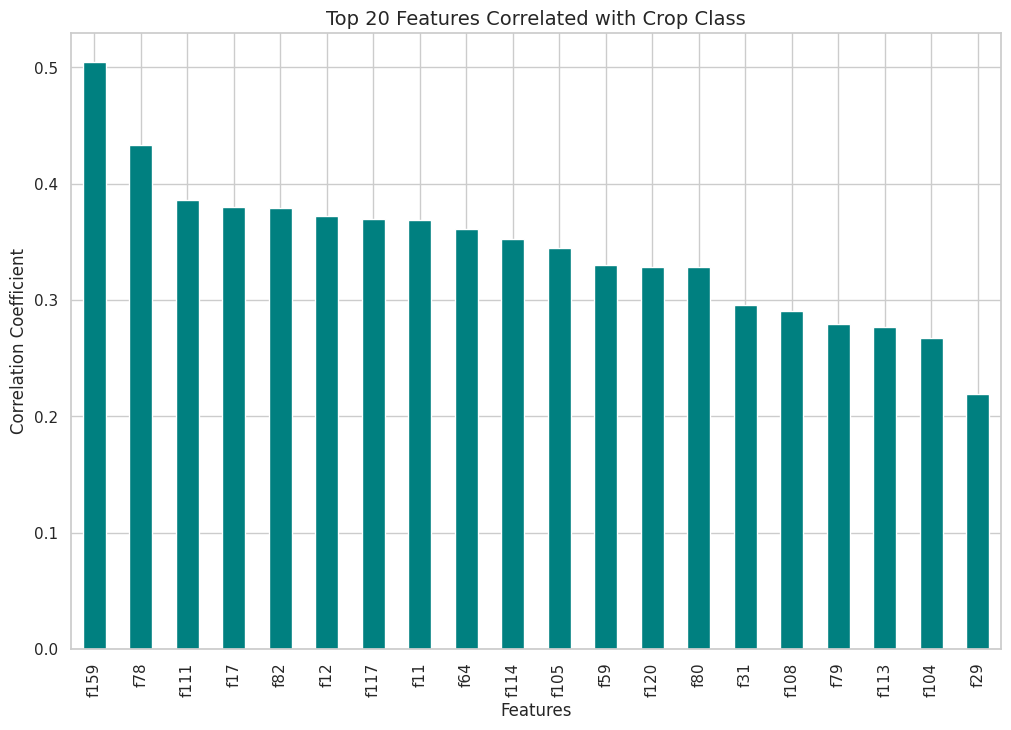

In [ ]:
# Calculate correlations with label (sampling for speed)
sample_df = df.sample(frac=0.1, random_state=42)
correlations = sample_df.corr()['label'].sort_values(ascending=False)

# Plot top correlations
plt.figure(figsize=(12,8))
correlations[1:21].plot(kind='bar', color='teal')
plt.title('Top 20 Features Correlated with Crop Class', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.show()

### 3.3 Feature Group Analysis

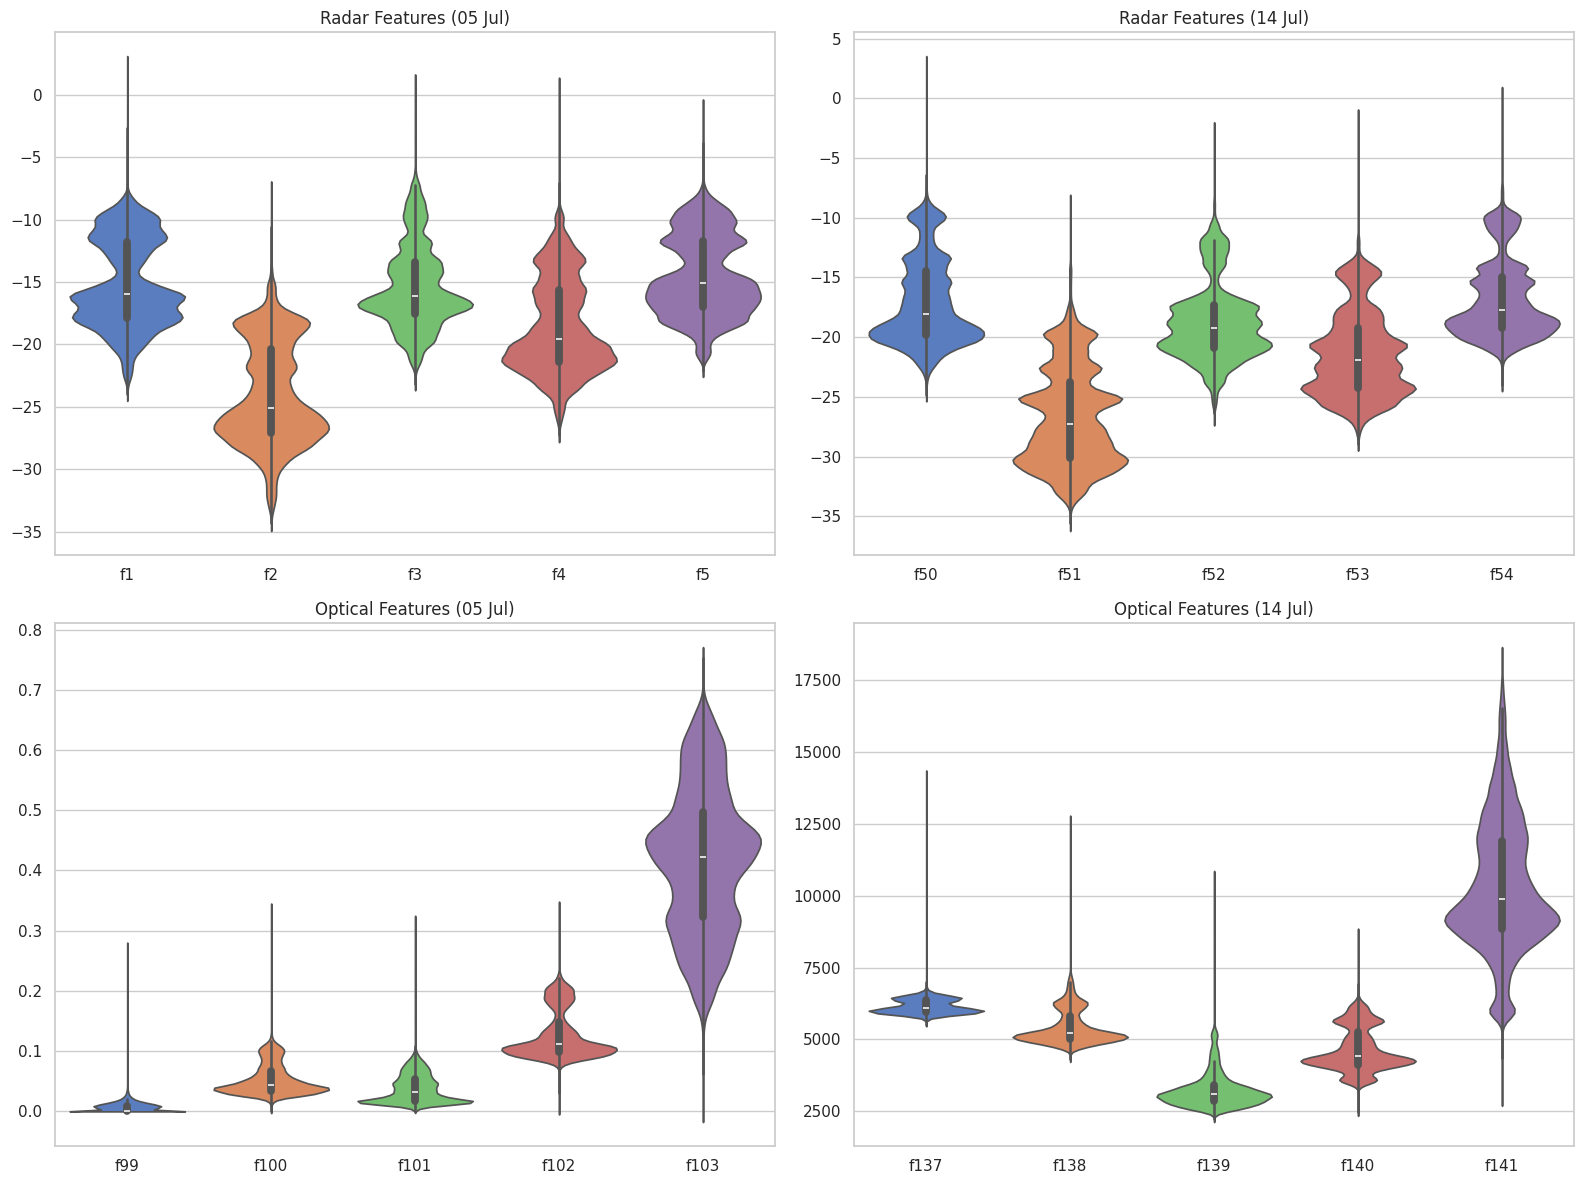

In [ ]:
# Radar vs Optical feature distributions
fig, ax = plt.subplots(2,2, figsize=(16,12))

# Radar features
sns.violinplot(data=df[radar_features_05jul[:5]], ax=ax[0,0])
ax[0,0].set_title('Radar Features (05 Jul)', fontsize=12)
sns.violinplot(data=df[radar_features_14jul[:5]], ax=ax[0,1])
ax[0,1].set_title('Radar Features (14 Jul)', fontsize=12)

# Optical features
sns.violinplot(data=df[optical_features_05jul[:5]], ax=ax[1,0])
ax[1,0].set_title('Optical Features (05 Jul)', fontsize=12)
sns.violinplot(data=df[optical_features_14jul[:5]], ax=ax[1,1])
ax[1,1].set_title('Optical Features (14 Jul)', fontsize=12)

plt.tight_layout()
plt.show()

### 3.4. Temporal Feature Comparison

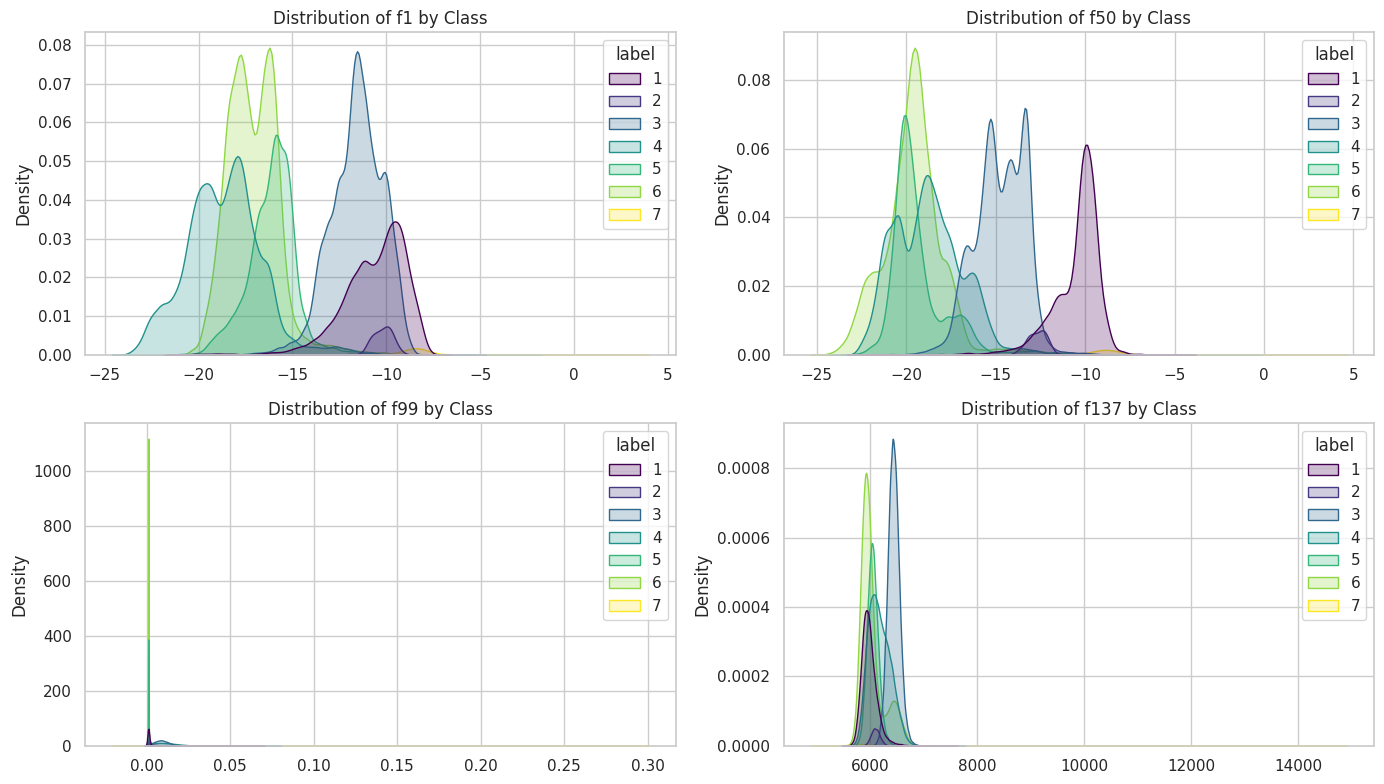

In [ ]:
# Compare temporal development for sample features
sample_features = ['f1', 'f50', 'f99', 'f137']  # Example features from different groups

plt.figure(figsize=(14,8))
for i, feat in enumerate(sample_features, 1):
    plt.subplot(2,2,i)
    sns.kdeplot(data=df, x=feat, hue='label', palette='viridis', fill=True)
    plt.title(f'Distribution of {feat} by Class')
    plt.xlabel('')
plt.tight_layout()
plt.show()

### 3.5. Dimensionality Reduction (PCA)

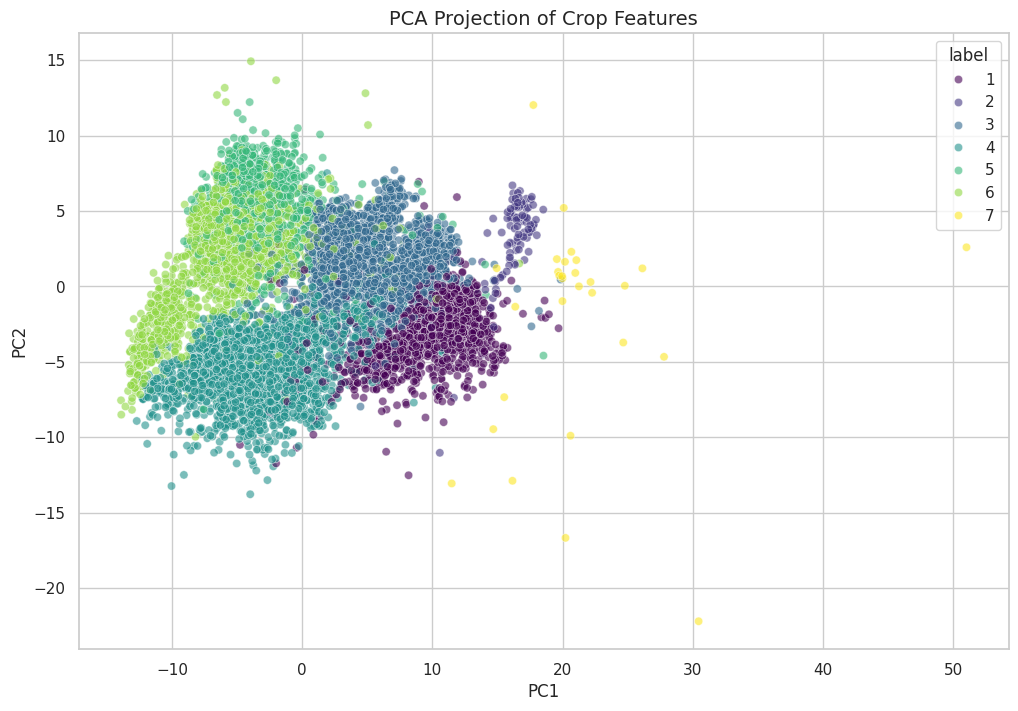

In [23]:
# Perform PCA on sampled data
sample_df = df.sample(n=10000, random_state=42)
X = sample_df.drop('label', axis=1)
y = sample_df['label']

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(12,8))
sns.scatterplot(x=principal_components[:,0], y=principal_components[:,1],
                hue=y, palette='viridis', alpha=0.6)
plt.title('PCA Projection of Crop Features', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.show()

### 3.6. Feature Temporal Differences

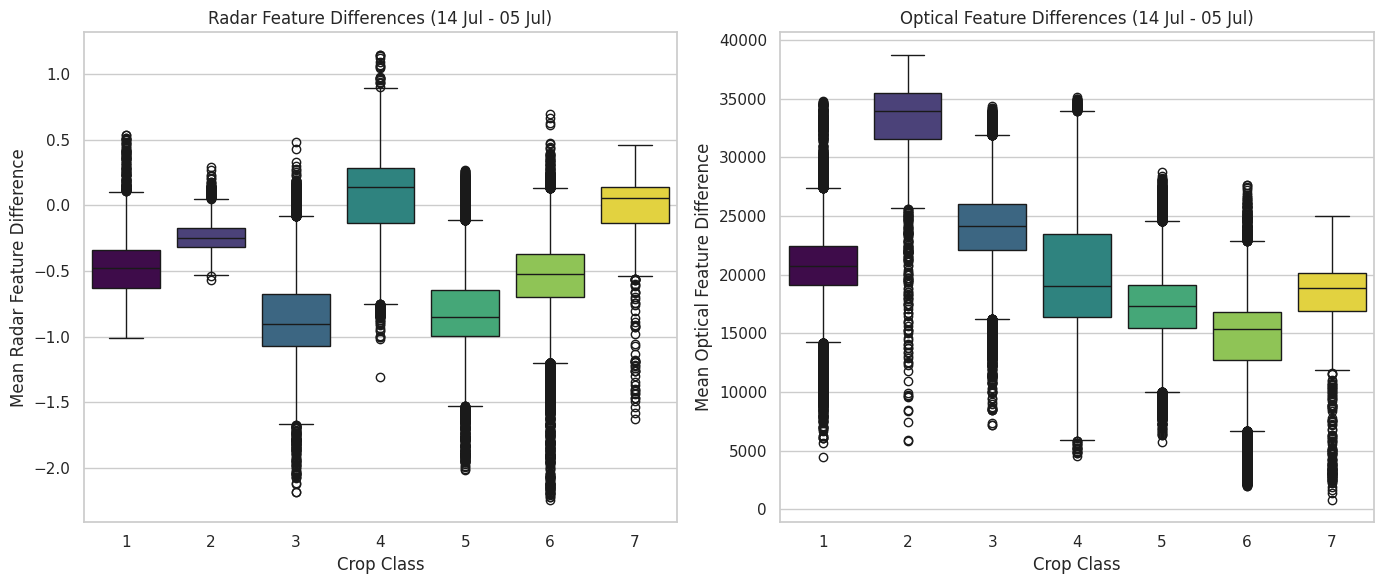

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compare feature means between dates
radar_diff = df[radar_features_14jul].mean(axis=1) - df[radar_features_05jul].mean(axis=1)
optical_diff = df[optical_features_14jul].mean(axis=1) - df[optical_features_05jul].mean(axis=1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['label'], y=radar_diff, hue=df['label'], palette='viridis', legend=False)
plt.title('Radar Feature Differences (14 Jul - 05 Jul)')
plt.xlabel('Crop Class')
plt.ylabel('Mean Radar Feature Difference')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['label'], y=optical_diff, hue=df['label'], palette='viridis', legend=False)
plt.title('Optical Feature Differences (14 Jul - 05 Jul)')
plt.xlabel('Crop Class')
plt.ylabel('Mean Optical Feature Difference')

plt.tight_layout()
plt.show()